The code loads SST anomalies data from last tutorial (saved in SST_anomalies_data.mat) then loads the .nc file of gridded monthly temperature data for BC.  Period: Jan 1979 to July 2017.  All the data pre-processing is done below.

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [2]:
#load SST data from .csv file and check it out; rows are months, columns are locations
dataSST = pd.read_csv('SST_anomalies_data.csv',header=None)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dataSST.head()
SST_extent=[-360+159.75,-360+260.25,-10.5,10.5] #these are just the known boundaries of the SST grid [lonmin,lonmax,latmin,latmax] for plotting


#load coastline data
coasts = pd.read_csv('coastline.csv',header=None)
coastLat = coasts[0]
coastLon = coasts[1]

In [3]:
#open netcdf file of temperature over BC

filename = 'T_monthly_Canada_1979_2017_ERA_Interim.nc'
dataERA = Dataset(filename)

lonERA = -360+dataERA.variables['longitude'][:] #in degrees E
latERA = dataERA.variables['latitude'][:] #in degrees N
timeERA = dataERA.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
T = dataERA.variables['t2m'] #in K

In [4]:
#reformat data from 3D to 2D, where rows are grid points, columns are months

T2d = np.empty((np.shape(T)[1]*np.shape(T)[2],np.shape(T)[0]))
for ii in range(np.shape(T)[0]):
    T2d[:,ii] = np.reshape(T[ii],(np.shape(T)[1]*np.shape(T)[2],))

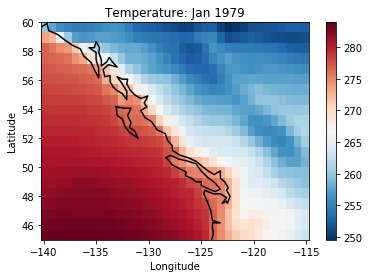

In [5]:
#plot temp over whole domain Jan 1979

lonERAmin = np.min(lonERA)
lonERAmax = np.max(lonERA)
latERAmin = np.min(latERA)
latERAmax = np.max(latERA)
T_extent = [lonERAmin,lonERAmax,latERAmin,latERAmax]
plt.imshow(np.asarray(np.squeeze(T[0,:,:])), extent=T_extent,cmap = 'RdBu_r',aspect='auto')
plt.plot(coastLon,coastLat,c='k')
plt.xlim(T_extent[:2])
plt.ylim(T_extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature: Jan 1979')
plt.colorbar()


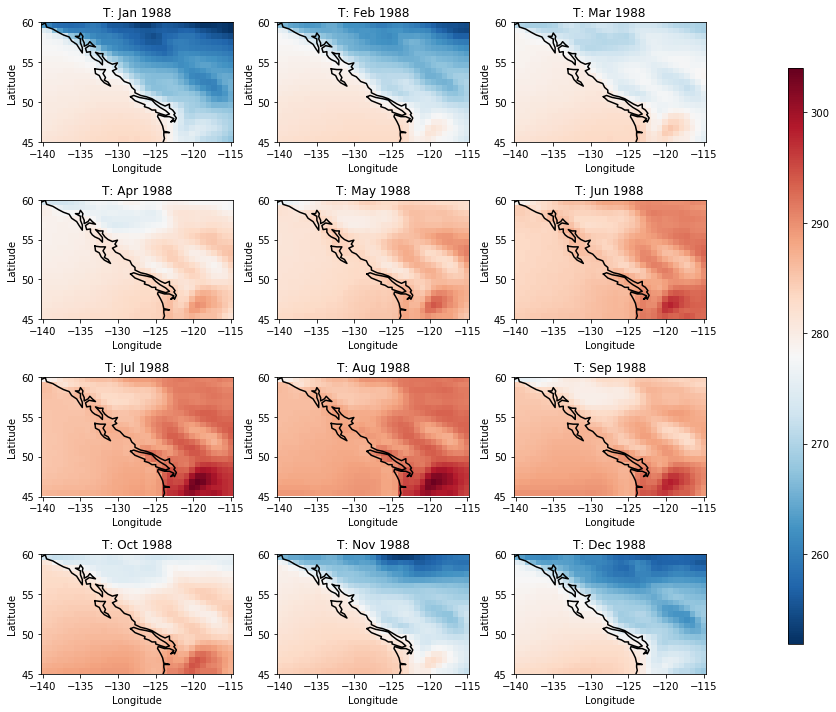

In [6]:
#plot temp for each month in 1988, since this year had a strong La Nina event

vmin = np.min([T[12*9+month,:,:] for month in range(12)])
vmax = np.max([T[12*9+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*9+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1988')
    #plt.colorbar()
    month+=1
 
plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

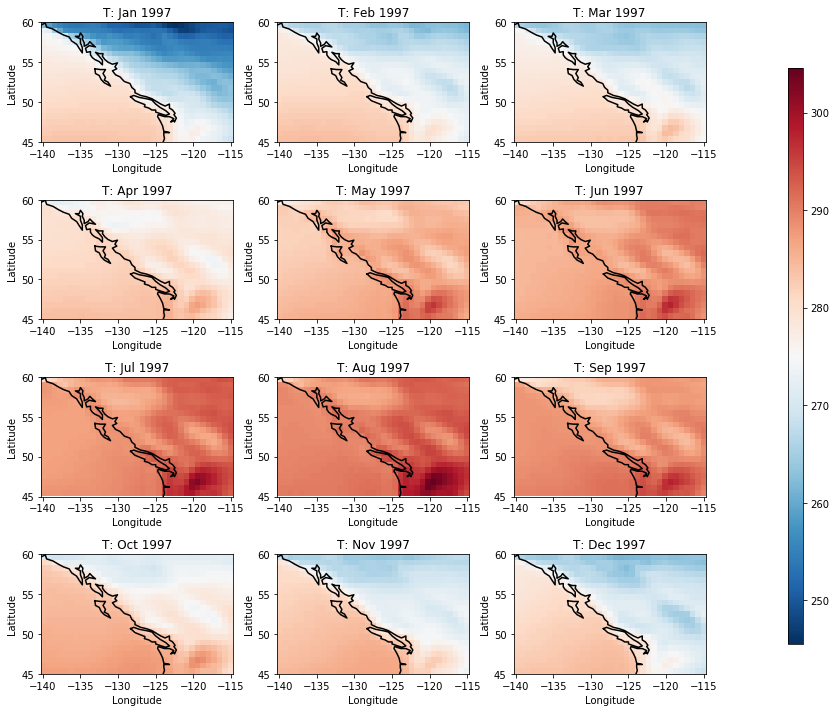

In [7]:
#plot temp for each month in 1997, since this year had a strong El Nino event

vmin = np.min([T[12*18+month,:,:] for month in range(12)])
vmax = np.max([T[12*18+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*18+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1
    
plt.tight_layout()    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

Preprocessing: remove seasonal cycle and apply 3-month running mean -- we want smoothed anomalies!



In [8]:
#remove last 7 months from 2017, so the timeseries line up
T_cut = T[:-7]
T2d_cut = T2d[:,:-7]

#calculate seasonal signal for each grid point
nyears = 38
T2d_seasonal = np.empty((np.shape(T2d)[0],12))
for ii in range(len(T2d_cut)):
    T2d_seasonal[ii,:] = np.mean(np.reshape(T2d_cut[ii,:],(nyears,12)),axis=0)

#repeat the seasonal cycle for all years
T2d_seasonal_all = np.tile(T2d_seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
T2d_anomalies = T2d_cut - T2d_seasonal_all

#apply 3-month running mean on each grid point 
T2d_anomalies_smooth = np.empty_like(T2d_anomalies)
N=3 #length of moving window
for ii in range(len(T2d_anomalies)):
    x=T2d_anomalies[ii,:]
    T2d_anomalies_smooth[ii,:] = np.convolve(x, np.ones((N,))/N, mode='same')


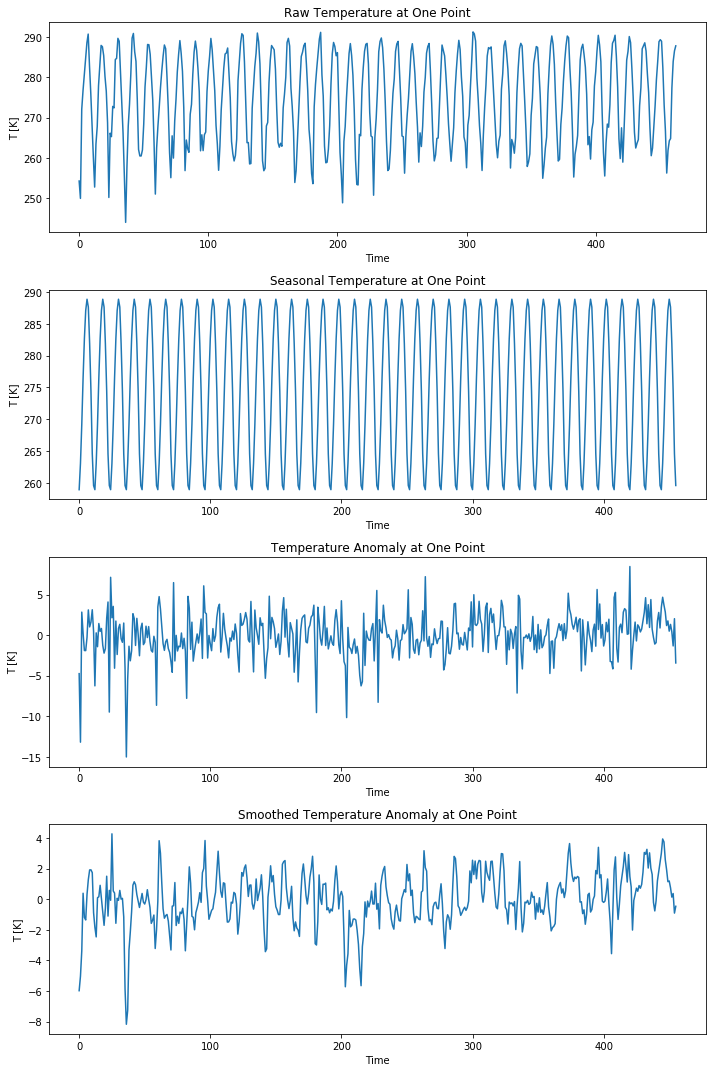

In [9]:
#let's visualize all of these great pre-processing steps!

gridIndex = 50 #arbitrary grid point to visualize the preprocessing for

plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
plt.plot(T2d[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Raw Temperature at One Point')

plt.subplot(4,1,2)
plt.plot(T2d_seasonal_all[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Seasonal Temperature at One Point')

plt.subplot(4,1,3)
plt.plot(T2d_anomalies[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Temperature Anomaly at One Point')

plt.subplot(4,1,4)
plt.plot(T2d_anomalies_smooth[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Smoothed Temperature Anomaly at One Point')

plt.tight_layout()
plt.show()


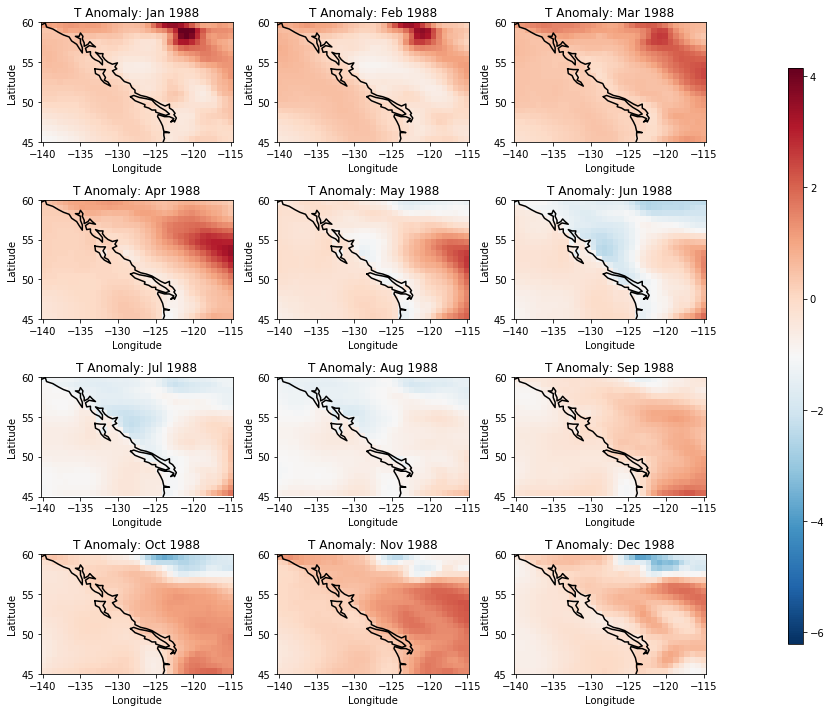

In [10]:
#plot the 3-month running mean of residuals for all grid points for all months of 1988

vmin = np.min([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*9+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1988')
    month+=1
    
plt.tight_layout()   
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

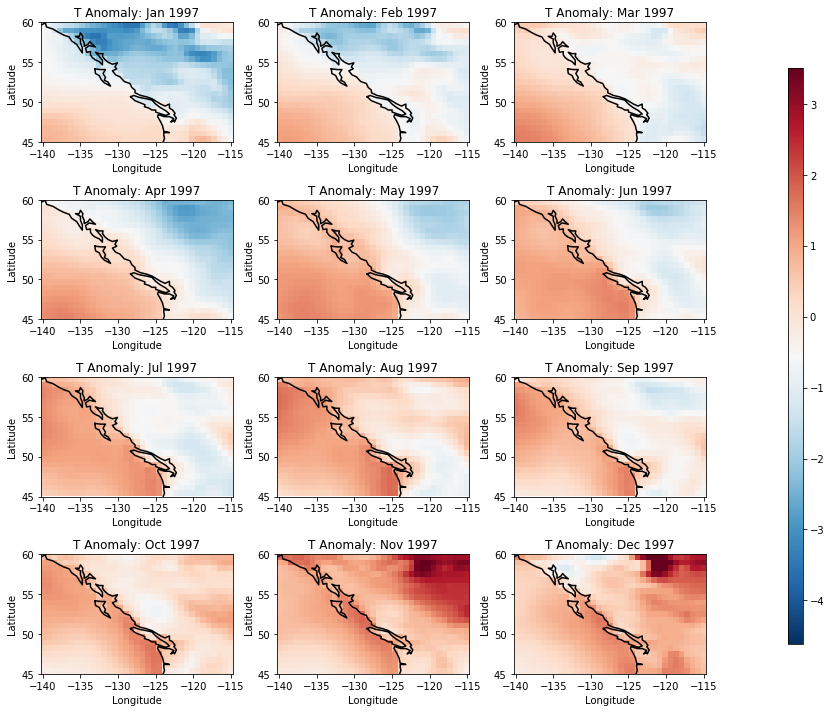

In [11]:
#plot the 3-month running mean of residuals for all grid points for all months of 1997

vmin = np.min([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*18+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1

plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

SOLUTIONS

Perform PCA on T anomaly data to find spatial modes

In [12]:
#do PCA using built-in library

data = T2d_anomalies_smooth.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

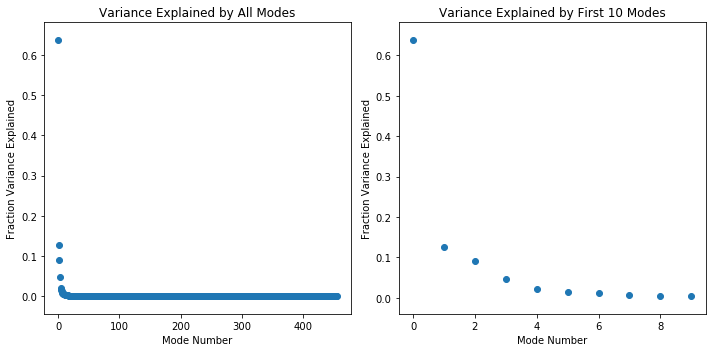

In [13]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

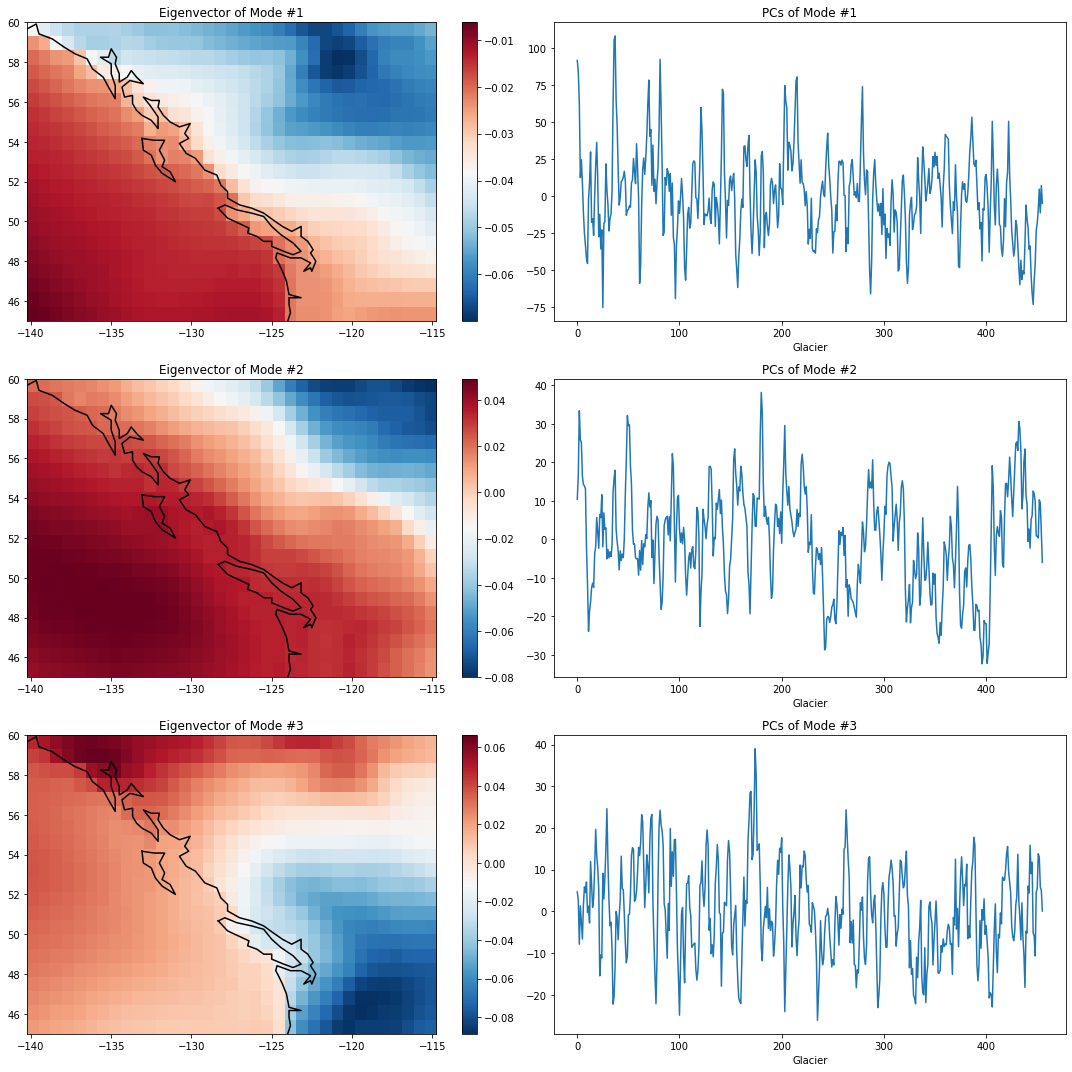

In [14]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs[kk,:],(21,35)),extent=T_extent,cmap = 'RdBu_r',aspect='auto')
    plt.plot(coastLon,coastLat,c='k')
    plt.xlim(T_extent[:2])
    plt.ylim(T_extent[2:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.tight_layout()

Now, do CCA:

In [15]:
#rows are time steps -- these must be the same in both x an y data
xdata = np.asarray(dataSST[:-4])
ydata = T2d_anomalies_smooth.T

#check shape
print('Shape of xdata: ' + str(np.shape(xdata)[0]) + ' rows, ' + str(np.shape(xdata)[1]) + ' columns')
print('Shape of ydata: ' + str(np.shape(ydata)[0]) + ' rows, ' + str(np.shape(ydata)[1]) + ' columns')

Shape of xdata: 456 rows, 3915 columns
Shape of ydata: 456 rows, 735 columns


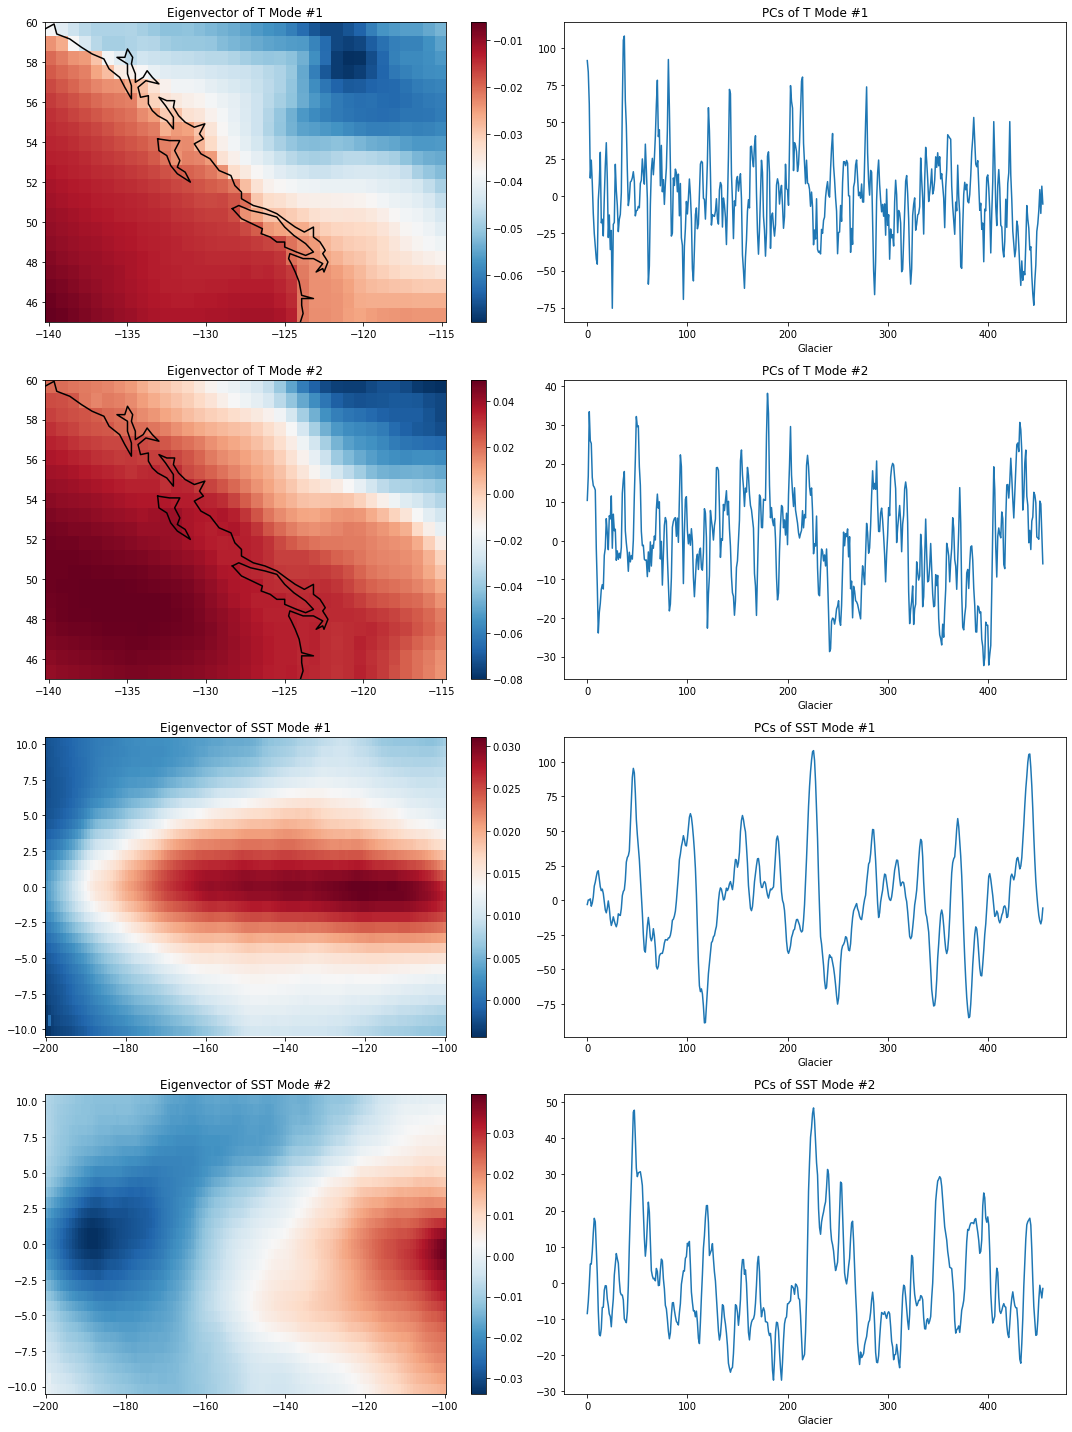

In [16]:
#do PCA on T and SST datasets so that CCA is finding modes which explain non-negligible fractions of total variance

pca_input_T = T2d_anomalies_smooth.T
n_modes_T = 2
pca_T = PCA(n_components = n_modes_T)
PCs_T = pca_T.fit_transform(pca_input_T)
eigvecs_T = pca_T.components_
fracVar_T = pca_T.explained_variance_ratio_

pca_input_SST = np.asarray(dataSST[:-4])
n_modes_SST = 2
pca_SST = PCA(n_components = n_modes_SST)
PCs_SST = pca_SST.fit_transform(pca_input_SST)
eigvecs_SST = pca_SST.components_
fracVar_SST = pca_SST.explained_variance_ratio_

#reconstruct T and SST, using first two modes for each dataset

numObs = np.shape(pca_input_T)[0]
data_T_rec = np.empty_like(pca_input_T)
for kk in range(numObs): #for each month
    this_T_rec = np.zeros_like(pca_input_T[0,:])
    for mode in range(n_modes_T):
        this_T_rec += eigvecs_T[mode,:]*PCs_T[kk,mode]    
    data_T_rec[kk,:] = this_T_rec
    
numObs = np.shape(pca_input_SST)[0]
data_SST_rec = np.empty_like(pca_input_SST)
for kk in range(numObs): #for each month
    this_SST_rec = np.zeros_like(pca_input_SST[0,:])
    for mode in range(n_modes_SST):
        this_SST_rec += eigvecs_SST[mode,:]*PCs_SST[kk,mode]    
    data_SST_rec[kk,:] = this_SST_rec
    
#visualize PCA modes

n = 2

plt.figure(figsize=(15,10*n))
for kk in range(n):
    
    plt.subplot(2*n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs_T[kk,:],(21,35)),extent=T_extent,cmap = 'RdBu_r',aspect='auto')
    plt.plot(coastLon,coastLat,c='k')
    plt.xlim(T_extent[:2])
    plt.ylim(T_extent[2:])
    plt.title('Eigenvector of T Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(2*n,2,(kk+1)*2)
    plt.plot(PCs_T[:,kk])
    plt.title('PCs of T Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.subplot(2*n,2,kk*2+5)
    plt.imshow(np.reshape(eigvecs_SST[kk,:],(29,135)),extent=SST_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('Eigenvector of SST Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(2*n,2,kk*2+6)
    plt.plot(PCs_SST[:,kk])
    plt.title('PCs of SST Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.tight_layout()


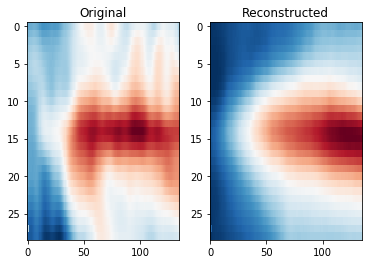

In [17]:
#visualize reconstruction -- and note that the more modes you include, the closer the reconstruction gets to the real thing

month = 100

cmap = 'RdBu_r'

plt.subplot(121)
plt.imshow(np.reshape(pca_input_SST[month,:],(29,135)), cmap = cmap, aspect='auto')
plt.title('Original')

plt.subplot(122)
plt.imshow(np.reshape(data_SST_rec[month,:],(29,135)), cmap = cmap, aspect='auto')
plt.title('Reconstructed')

plt.show()

In [18]:
#do CCA!

xdata = data_SST_rec
ydata = data_T_rec

n_modes = 10 #modes to keep
cca = CCA(n_components=n_modes,max_iter = 10000)
U,V = cca.fit_transform(xdata,ydata)
A = cca.x_weights_
B = cca.y_weights_
F = np.cov(xdata.T)@A
G = np.cov(ydata.T)@B
r = [np.corrcoef(U[:,ii],V[:,ii]) for ii in range(n_modes)]

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [19]:
#we want U, V to be normalized to have unity variance for easier visual comparison

normx = np.empty_like(U[0,:])
normy = np.empty_like(normx)

for ind in range(len(U[0,:])):
    
    normx[ind] = np.std(U[:,ind])
    normy[ind] = np.std(V[:,ind])
    
    U[:,ind]=U[:,ind]/normx[ind]
    V[:,ind]=V[:,ind]/normy[ind]

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


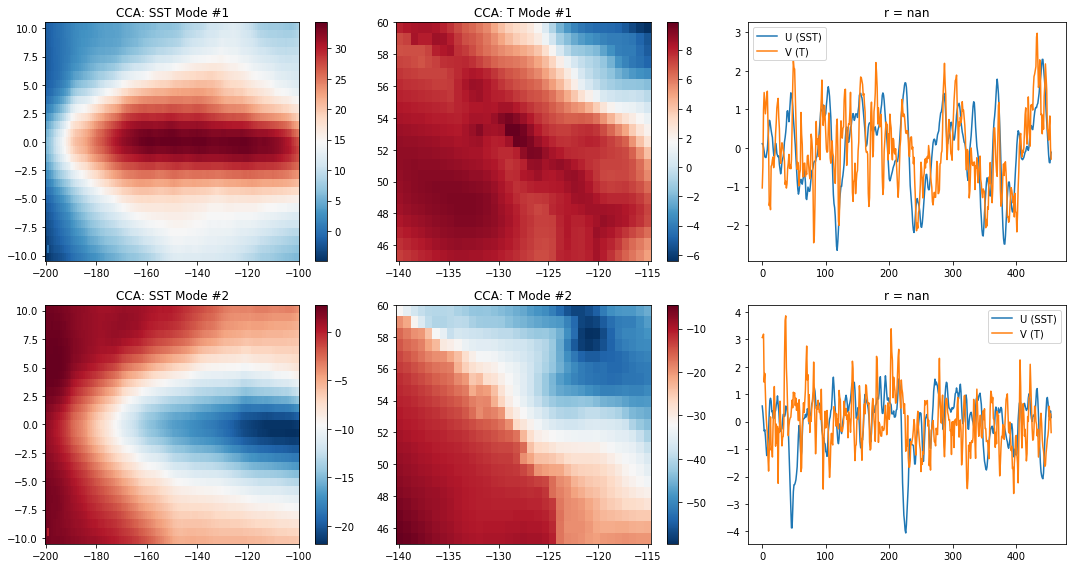

In [20]:
#plot first n CCA modes of SST (F), T (G), and their loadings (u,v)

n = 2

cmap = 'RdBu_r'

plt.figure(figsize=(15,8))

for mode in range(n):

    plt.subplot(2,3,3*mode+1)
    plt.imshow(np.reshape(F[:,mode],(29,135)),cmap=cmap,extent=SST_extent,aspect='auto')
    plt.title('CCA: SST Mode #' + str(mode+1))
    plt.colorbar()

    plt.subplot(2,3,3*mode+2)
    plt.imshow(np.reshape(G[:,mode],(21,35)),cmap=cmap,extent=T_extent,aspect='auto')
    plt.title('CCA: T Mode #' + str(mode+1))
    plt.colorbar()

    plt.subplot(2,3,3*mode+3)
    plt.plot(U[:,mode])
    plt.plot(V[:,mode])
    plt.legend(['U (SST)','V (T)'])
    plt.title('r = ' + str(r[n][0,1])[:4])

plt.tight_layout()
plt.show()